#### Demo of the Training pipeline

In [33]:
import os
import torch
import json
import random
import pyewts
import logging
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt

from tqdm import tqdm
from glob import glob
from datetime import datetime
from natsort import natsorted
from torch.nn import CTCLoss
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

from IPython.display import Image as ShowImage

from src.Models import VanillaCRNN
from src.Datasets import CTCDataset, ctc_collate_fn
from src.Augmentations import train_transform

from config import N_DEFAULT_CHARSET
from src.Utils import create_dir, shuffle_data, read_data, get_filename

logging.getLogger().setLevel(logging.INFO)

print(torch.__version__)

2.1.1


In [2]:
def show_image(image: np.array, cmap: str = "", axis="off") -> None:
    plt.figure(figsize=(24, 13))
    plt.axis(axis)
    
    if cmap != "":
        plt.imshow(image, cmap=cmap)
    else:
        plt.imshow(image)

#### Setup Data

In [9]:
def split_dataset(image_paths: list[str], label_paths: list[str], batch_size: int = 32, even_splits: bool = True, train_val_split: float = 0.8, val_test_split: float = 0.5):

    """
    Splitting the dataset evenly for the selected batch size.
    """

    batches = len(image_paths) // batch_size
    train_batches = int(batches * train_val_split)

    train_images = image_paths[:train_batches*batch_size]
    train_labels = label_paths[:train_batches*batch_size]

    assert len(train_images) % batch_size == 0 and len(train_labels) % batch_size == 0

    val_test_images = image_paths[train_batches*batch_size:]
    val_test_labels = label_paths[train_batches*batch_size:]
    val_test_split = int(((len(val_test_images) * val_test_split) // batch_size) * batch_size)

    val_images = val_test_images[:val_test_split]
    val_labels = val_test_labels[:val_test_split]

    test_images = val_test_images[val_test_split:]
    test_labels = val_test_labels[val_test_split:]

    if even_splits:
        test_images = test_images[:(len(test_images) // batch_size)*batch_size]
        test_labels = test_labels[:(len(test_images) // batch_size)*batch_size]

    print(f"Train Images: {len(train_images)}, Train Labels: {len(train_labels)}")
    print(f"Val Images: {len(val_images)}, Val Labels: {len(val_labels)}")
    print(f"Test Images: {len(test_images)}, Test Labels: {len(test_labels)}")

    assert len(train_images) % batch_size == 0 and len(train_labels) % batch_size == 0
    assert len(val_images) % batch_size == 0 and len(val_labels) % batch_size == 0
    assert len(test_images) % batch_size == 0 and len(test_labels) % batch_size == 0

    return train_images, train_labels, val_images, val_labels, test_images, test_labels

In [10]:
def save_data(output_dir: str, samples: list[str], distribution: str = "train"):
    out_file = f"{output_dir}/{distribution}_data.txt"

    with open(out_file, "w") as f:
        for img in samples:
            img_n = os.path.basename(img).split(".")[0]
            f.write(f"{img_n}\n")

In [11]:
converter = pyewts.pyewts()
training_time = datetime.now()

data_dir = "Datasets"
dataset_name = "KhyentseWangpo"
ds_dir = os.path.join(data_dir, dataset_name)

output_dir = os.path.join(ds_dir, "Output", f"{training_time.year}_{training_time.month}_{training_time.day}_{training_time.hour}_{training_time.minute}")
create_dir(output_dir)

images = natsorted(glob(f"{ds_dir}/lines/*.jpg"))
labels = natsorted(glob(f"{ds_dir}/transcriptions/*.txt"))

print(f"All Images: {len(images)}, All Labels:{len(labels)}")

assert len(images) == len(labels)

batch_size = 32
images, labels = shuffle_data(images, labels)
train_images, train_labels, val_images, val_labels, test_images, test_labels = split_dataset(images, labels)

All Images: 13527, All Labels:13527
Train Images: 10784, Train Labels: 10784
Val Images: 1344, Val Labels: 1344
Test Images: 1376, Test Labels: 1376


In [14]:
train_labels[:10]

['Datasets\\KhyentseWangpo/transcriptions\\I1KG811170368_1.txt',
 'Datasets\\KhyentseWangpo/transcriptions\\I1KG811270508_3.txt',
 'Datasets\\KhyentseWangpo/transcriptions\\I1KG811170407_1.txt',
 'Datasets\\KhyentseWangpo/transcriptions\\I1KG811160566_0.txt',
 'Datasets\\KhyentseWangpo/transcriptions\\I1KG811160452_1.txt',
 'Datasets\\KhyentseWangpo/transcriptions\\I1KG811160216_4.txt',
 'Datasets\\KhyentseWangpo/transcriptions\\I1KG811170335_4.txt',
 'Datasets\\KhyentseWangpo/transcriptions\\I1KG811270037_0.txt',
 'Datasets\\KhyentseWangpo/transcriptions\\I1KG811270306_5.txt',
 'Datasets\\KhyentseWangpo/transcriptions\\I1KG811270128_5.txt']

In [15]:
# save train data
save_data(output_dir, train_images, "train")
save_data(output_dir, val_images, "val")
save_data(output_dir, test_images, "test")

In [16]:
train_images, train_labels = read_data(train_images, train_labels, converter, min_label_length=0, max_label_length=400)
valid_images, valid_labels = read_data(val_images, val_labels, converter, min_label_length=0, max_label_length=400)

print(f"Train Images: {len(train_images)}, Train Labels: {len(train_labels)}")
print(f"Valid Images: {len(valid_images)}, Valid Images: {len(valid_labels)}")

reading labels: 100%|██████████| 1344/1344 [00:01<00:00, 982.46it/s]

Train Images: 10772, Train Labels: 10772
Valid Images: 1343, Valid Images: 1343


In [17]:
# check label encoding
train_labels[:4]

["yang§dag§skye§'gyur§ba//bsgom§pa'i§cho§ga§rnam§bshad§nas//rnam§grangs§dag§kyang§yongs§su§bstan//de§bzhin§nyid§dang§yang§dag§mtha'//bsam§gyis§mi§khyab§pa§yi§dbyings//chos§nyid§dang§ni§chos§skyon§",
 "byon|/'gro§ba'i§gnyen§gyur§sras§dang§bcas§pa§kun//srid§pa'i§mun§nag§'thib§po§bsal§slad§du//'gro§ba§ji§srid§sgron§me§mdzad§par§gsol//yon§tan§dger§'os§rgyal§ba'i§byang§chub§",
 "bsgrub//ces§pa'i§bar§ro//de§dang§ldan§pa§la§gsang§dbang§bskur§tshul§bstan§pa§ni/de§yang§thun§mong§dang§bcas§pa//sogs§nas/bcu§gnyis§don§du§rtogs§par§'gyur//bar§ro//de§nas§zhing§",
 "dri§yi§rdo§rje§mar§byas§nas//dkyil§'khor§lha§tshogs§rnams§la§dbul§bar§bgyi//zhes§gsungs§pa§sogs§spyi§dang§bye§brag§tu§bstan§pa'i§tshogs§de§dag§las/slob§dpon§pad+ma§la§sogs§mkhas§grub§rnams§"]

In [19]:
target_width = 2000
target_height = 80
num_workers = 4
persistent_workers = True
charset = N_DEFAULT_CHARSET

train_dataset = CTCDataset(images=train_images, labels=train_labels, img_height=target_height, img_width=target_width, charset=charset, augmentations=train_transform)
valid_dataset = CTCDataset(images=valid_images, labels=valid_labels, img_height=target_height, img_width=target_width, charset=charset)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=ctc_collate_fn,
    drop_last=True,
    num_workers=num_workers,
    persistent_workers=persistent_workers)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=ctc_collate_fn,
    drop_last=True,
    num_workers=num_workers,
    persistent_workers=persistent_workers)

In [20]:
# checking the loaders work correctly
# CAUTION: executes a full run over the entire data, might take a while on large input sizes
train_sample = next(iter(train_loader))
valid_sample = next(iter(valid_loader))

(80, 2000, 1)


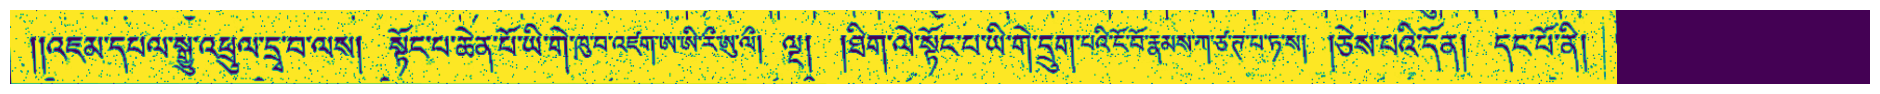

In [26]:
# check one sample
image, label, label_length = train_sample
image = image.numpy()
batch_img_idx = random.randint(0, 31)
n_image = image[batch_img_idx]
n_image = np.transpose(n_image, axes=[1, 2, 0])
print(n_image.shape)

show_image(n_image)

Define a CRNN Model and Training Parameters

In [27]:
device = "cuda"
target_width = 2000
target_height = 80
map_to_seq_hidden = 64
rnn_hidden = 256
leaky_relu = False
learning_rate = 0.0005
num_classes = len(charset)+1
rnn = "lstm"

torch.cuda.empty_cache()
network = VanillaCRNN(rnn=rnn, charset_size=num_classes)
network.to(device)

optimizer = optim.RMSprop(network.parameters(), lr=learning_rate)
#lr_scheduler = ReduceLROnPlateau(optimizer, factor=0.8, patience=5, verbose=True)

criterion = CTCLoss(reduction='sum', zero_infinity=True)
criterion.to(device)

CTCLoss()

In [29]:
# check the flow of data through the model doesn't produce errors
x = torch.randn([1, 1, 80, 2000], device=device, requires_grad=True)
network_out = network(x)

print(network_out.shape)

torch.Size([499, 1, 77])


#### Train Loop

In [30]:
def train_batch(network, data, optimizer, criterion, device):
    network.train()
    images, targets, label_lengths = [d.to(device) for d in data]

    logits = network(images)
    log_probs = torch.nn.functional.log_softmax(logits, dim=2)

    batch_size = images.size(0)
    input_lengths = torch.LongTensor([logits.size(0)] * batch_size)
    label_lengths = torch.flatten(label_lengths)

    loss = criterion(log_probs, targets, input_lengths, label_lengths)

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(network.parameters(), 5) # gradient clipping with 5
    optimizer.step()

    return loss.item()

In [31]:
def save_checkpoint(network, optimizer, save_path):
    checkpoint = {"state_dict": network.state_dict(), "optimizer": optimizer.state_dict()}  
    torch.save(checkpoint, save_path)
    
    logging.info(f"Saved Model Checkpoint at {save_path}")


def check_accuracy(network, val_loader, criterion):
    val_ctc_losses = []
    network.eval()

    for _, val_data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        with torch.no_grad():
            images, targets, target_lengths = [d.to(device) for d in val_data]

            logits = network(images)
            log_probs = torch.nn.functional.log_softmax(logits, dim=2)

            batch_size = images.size(0)
            input_lengths = torch.LongTensor([logits.size(0)] * batch_size)
            target_lengths = torch.flatten(target_lengths)

            loss = criterion(log_probs, targets, input_lengths, target_lengths)
            val_ctc_losses.append(loss / batch_size)

    val_loss = torch.mean(torch.tensor(val_ctc_losses))
    network.train()

    return val_loss.item()

In [32]:
def train(network, train_loader, val_loader, checkpoint_path: str, epochs: int = 10):
    train_iteration = 1

    train_loss_history = []
    val_loss_history = []
    best_loss = None

    for epoch in range(1, epochs + 1):
        epoch_train_loss = 0
        tot_train_count = 0

        for _, data in tqdm(enumerate(train_loader), total=len(train_loader)):

            loss = train_batch(network, data, optimizer, criterion, device)
            train_size = data[0].size(0) # batch_size

            epoch_train_loss += loss
            tot_train_count += train_size

        train_iteration += 1

        train_loss = epoch_train_loss / tot_train_count
        train_loss_history.append(train_loss)

        val_loss = check_accuracy(network, val_loader, criterion)
        val_loss_history.append(val_loss)

        logging.info(f"Epoch {epoch} => train_loss: {train_loss}, val loss: {val_loss}")

        if best_loss is None:
            best_loss = val_loss
            save_checkpoint(network, optimizer, checkpoint_path)

        elif val_loss < best_loss:
            save_checkpoint(network, optimizer, checkpoint_path)

    return train_loss_history, val_loss_history

In [34]:
model_save_path = f"{output_dir}/{dataset_name}.pth"
train_losses, val_losses = train(network, train_loader, valid_loader, model_save_path, epochs=2)

  2%|▏         | 7/336 [03:56<2:43:00, 29.73s/it]

#### Save Model data and training results

In [30]:
train_losses_out = f"{output_dir}/train_lossses.txt"
val_losses_out = f"{output_dir}/val_lossses.txt"

with open(train_losses_out, "w") as f:
  f.write(str(train_losses))

with open(val_losses_out, "w") as f:
  f.write(str(val_losses))

#### Evaluate model on test lines

In [7]:
import cv2
import pyewts
import torch
from evaluate import load
from src.Models import VanillaCRNN
from src.Utils import resize_n_pad
from fast_ctc_decode import viterbi_search
from config import DEFAULT_CHARSET, OLD_DEFAULT_CHARSET

converter = pyewts.pyewts()
cer_scorer = load("cer")

pred_charset = f"ß{DEFAULT_CHARSET}"
old_pred_charset = f"ß{OLD_DEFAULT_CHARSET}"

In [23]:
checkpoint_path = "Checkpoints/2023_8_1_6_5"
checkpoint_file = "LhasaKanjur.pth"
inference_model = VanillaCRNN(rnn="lstm", charset_size=len(OLD_DEFAULT_CHARSET)+1)
checkpoint = torch.load(os.path.join(checkpoint_path, checkpoint_file))
inference_model.load_state_dict(checkpoint['state_dict'])

inference_model.eval()
cer_metric = load("cer")

In [49]:
test_set = "Datasets/LhasaKanjur/Testset"
lines = natsorted(glob(f"{test_set}/lines/*.jpg"))
labels = natsorted(glob(f"{test_set}/transcriptions/*.txt"))

print(f"Test images: {len(lines)}, Ground Truth labels: {len(labels)}")

Test images: 11, Ground Truth labels: 11


In [50]:
def prepare_test_image(image_path: str, normalization: str = "simple") -> torch.FloatTensor:
    t_img= cv2.imread(image_path, 0)
    t_img = resize_n_pad(t_img, target_height=80, target_width=2000, padding="white")

    if normalization == "simple":
        t_img /= 255.0
    else:
        t_img = (t_img / 127.5) - 1.0
    t_img = np.array(t_img)
    t_img = np.expand_dims(t_img, axis=0) # add channel dimension
    t_img = np.expand_dims(t_img, axis=0) # add channel batch dimension, so that: BxCxHxW
    t_img = torch.FloatTensor(t_img)

    return t_img

def read_label(gt_file: str) -> str:
    f = open(gt_file, "r", encoding="utf-8")
    return f.readline()

OCR: ཕྱིར་བྱང་ཆུབ་སེམས་དཔའ་སེམས་དཔའ་ཆེན་པོས་སྦྱིན་པ་སྦྱིན་པར་བྱའོ། །རིགས་ཀྱི་བུ། གཞན་ཡང་ཆོས་གཉིས་ཐོབ་པར་བྱ་བའི་ཕྱིར་བྱང་ཆུབ་སེམས་དཔའ་སེམས་དཔའ་
Label: ཕྱིར་བྱང་ཆུབ་སེམས་དཔའ་སེམས་དཔའ་ཆེན་པོས་སྦྱིན་པ་སྦྱིན་པར་བྱའོ། །རིགས་ཀྱི་བུ། གཞན་ཡང་ཆོས་གཉིས་ཐོབ་པར་བྱ་བའི་ཕྱིར་བྱང་ཆུབ་སེམས་དཔའ་སེམས་དཔའ་
CER: 0.0


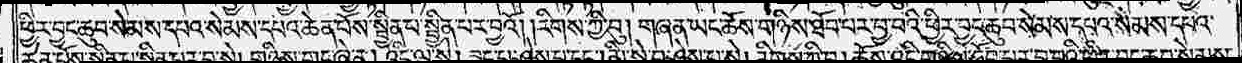

In [53]:
line_idx = 7
t_image = prepare_test_image(lines[line_idx])
predictions = inference_model(t_image)
np_predictions = predictions.cpu().detach().numpy()
np_predictions = np.squeeze(np_predictions, axis=1)

gt_lbl = read_label(labels[line_idx])

ocr_output, _ = viterbi_search(np_predictions, old_pred_charset)
ocr_output = converter.toUnicode(ocr_output)
print(f"OCR: {ocr_output}")
print(f"Label: {gt_lbl}")
cer_score = cer_scorer.compute(predictions=[ocr_output], references=[gt_lbl])
print(f"CER: {cer_score}")

ShowImage(lines[line_idx])

#### Run predictions on all test lines and compute CER

In [54]:
cer_scores = []

for line, label in tqdm(zip(lines, labels), total=len(lines)):

    t_img = prepare_test_image(line)
    lbl = read_label(label)
    
    predictions = inference_model(t_img)
    np_predictions = predictions.cpu().detach().numpy()
    np_predictions = np.squeeze(np_predictions, axis=1)
    ocr_output, _ = viterbi_search(np_predictions, old_pred_charset)
    unicode_ocr = converter.toUnicode(ocr_output)

    cer_score = cer_scorer.compute(predictions=[unicode_ocr], references=[lbl])
    cer_scores.append(cer_score)

print(cer_scores)

mean_cer = np.mean(cer_scores)
print(mean_cer)

  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [00:05<00:00,  1.84it/s]

[0.05263157894736842, 0.0, 0.025806451612903226, 0.01875, 0.8869565217391304, 0.0, 0.006896551724137931, 0.0, 0.012987012987012988, 0.025974025974025976, 0.0]
0.09363655845314355


#### Export to ONNX

In [56]:
import torch.onnx

from onnxruntime.quantization import QuantType  # type: ignore
from onnxruntime.quantization.quantize import quantize_dynamic

In [61]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

batch_size = 1
x = torch.randn([1, 1, 80, 2000], device=DEVICE, requires_grad=True)
inference_model.to(DEVICE)
#model_input =  torch.randn([1, 3, PATCH_SIZE, PATCH_SIZE], device=DEVICE)

# Export the model
torch.onnx.export(inference_model,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  f"{checkpoint_path}/LhasaKanjur.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=17,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})

In [62]:
quantize_dynamic(
            model_input=f"{checkpoint_path}/LhasaKanjur.onnx",
            model_output=f"{checkpoint_path}/LhasaKanjur_Torch_q.onnx",
            per_channel=False,
            reduce_range=False,
            weight_type=QuantType.QUInt8,
        )

INFO:root:Quantization parameters for tensor:"input" not specified
INFO:root:Quantization parameters for tensor:"/max_pool_0/MaxPool_output_0" not specified
INFO:root:Quantization parameters for tensor:"/max_pool_1/MaxPool_output_0" not specified
INFO:root:Quantization parameters for tensor:"/conv_block_2/Relu_output_0" not specified
INFO:root:Quantization parameters for tensor:"/max_pool_2/MaxPool_output_0" not specified
INFO:root:Quantization parameters for tensor:"/conv_block_4/Relu_output_0" not specified
INFO:root:Quantization parameters for tensor:"/max_pool_3/MaxPool_output_0" not specified
INFO:root:Quantization parameters for tensor:"/Transpose_output_0" not specified
INFO:root:Quantization parameters for tensor:"/rnn2/Reshape_output_0" not specified
